In [1]:
! pip install qiskit -q

     |████████████████████████████████| 6.1 MB 4.7 MB/s 
     |████████████████████████████████| 17.9 MB 437 kB/s 
     |████████████████████████████████| 237 kB 49.9 MB/s 
     |████████████████████████████████| 207 kB 49.3 MB/s 
     |████████████████████████████████| 2.1 MB 35.4 MB/s 
     |████████████████████████████████| 634 kB 51.5 MB/s 
     |████████████████████████████████| 1.4 MB 53.0 MB/s 
     |████████████████████████████████| 52 kB 1.2 MB/s 
     |████████████████████████████████| 49 kB 5.2 MB/s 
     |████████████████████████████████| 943 kB 54.6 MB/s 
     |████████████████████████████████| 38.2 MB 76.3 MB/s 
     |████████████████████████████████| 3.6 MB 51.4 MB/s 
     |████████████████████████████████| 6.3 MB 28.0 MB/s 


In [2]:
from qiskit import *
from qiskit import IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
import skimage.color
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('bmh')
import math
from skimage.transform import resize
from sklearn.svm import SVC
import cv2
import time

In [16]:
#@title ImageUtils code preprocessing, spliting, merging
class ImageUtils(object):
  #1. resize to 8 pixels
  #2. convert RGB to gray scale
  #3. apply OTSU threshold to enhance image
  #4. convert image to floating point
  @staticmethod
  def preProcess(image,verbose=False):
    image = resize(image, (32,32),anti_aliasing=True)
    if verbose:
      print(image.shape)

    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    bg=cv2.morphologyEx(image, cv2.MORPH_DILATE, cv2.getStructuringElement(cv2.MORPH_RECT , (8,8)))
    out_gray=cv2.divide(image, bg, scale=255)
    out_gray = out_gray.astype(np.uint8)
    image=cv2.threshold(out_gray, 0, 255, cv2.THRESH_OTSU )[1]
    if image.max() > 1.0:
      image = image[:,:]/255
    return image
  
  #split image in N image_crop_size blocks
  @staticmethod
  def split_image(image,image_crop_size):
    (imageWidth, imageHeight)=image.shape
    gridx = gridy = image_crop_size
    image_splits = []
    for h in range(0,imageHeight,gridy):
        for w in range(0,imageWidth,gridx):
            slice_bit = image[h:h+gridy, w:w+gridx]
            if slice_bit.max() > 1.0:
              slice_bit = slice_bit / 255
            image_splits.append(slice_bit)
    # print(len(image_splits), len(image_splits[0]),len(image_splits[-1]))
    assert len(image_splits) != len(image_splits[0]) and len(image_splits[-1])
    return image_splits

  #Helper function for concat_tile
  @staticmethod
  def hconcat_resize_min(im_list, interpolation=cv2.INTER_CUBIC):
    h_min = min(im.shape[0] for im in im_list)
    im_list_resize = [cv2.resize(im, (int(im.shape[1] * h_min / im.shape[0]), h_min), interpolation=interpolation) for im in im_list]
    return cv2.hconcat(im_list_resize)
  #Helper function for concat_tile
  @staticmethod
  def vconcat_resize_min(im_list, interpolation=cv2.INTER_CUBIC):
      w_min = min(im.shape[1] for im in im_list)
      im_list_resize = [cv2.resize(im, (w_min, int(im.shape[0] * w_min / im.shape[1])), interpolation=interpolation) for im in im_list]
      return cv2.vconcat(im_list_resize)
  # Helper function for mergeAndDisplay : 2d Grid of Images, output: merged image
  @staticmethod
  def concat_tile_resize(im_list_2d, interpolation=cv2.INTER_CUBIC):
      im_list_v = [ImageUtils.hconcat_resize_min(im_list_h, interpolation=cv2.INTER_CUBIC) for im_list_h in im_list_2d]
      return ImageUtils.vconcat_resize_min(im_list_v, interpolation=cv2.INTER_CUBIC)
  
  # input: 1D list of image splits, number of patches in one row
  @staticmethod
  def mergeAndDisplay(image_splits, patch_per_line,verbose=False):
    img_list = []
    cur = []
    for i,img in enumerate(image_splits):
      if i!=0 and i % patch_per_line == 0:
        img_list.append(cur)
        cur = []
      cur.append(img)
    img_list.append(cur)
    im_tile_resize = ImageUtils.concat_tile_resize(img_list)
    if verbose:
      plt.imshow(im_tile_resize)
      plt.show()
    return im_tile_resize

In [19]:
#@title QuantumProcessor code:- simulator circuit todo: real quantum machine
class QuantumProcessor(object):
  def __init__(self,image_crop_size):
    # Initialize some global variable for number of qubits
    self.image_crop_size = image_crop_size
    self.data_qb = math.ceil(math.log2(image_crop_size**2))
    anc_qb = 1
    self.total_qb = self.data_qb + anc_qb
    print('total qbits ' ,self.total_qb)
    # Initialize the amplitude permutation unitary
    self.D2n_1 = np.roll(np.identity(2**self.total_qb), 1, axis=1)

  # Convert the raw pixel values to probability amplitudes
  def amplitude_encode(self,img_data):
    rms = np.sqrt(np.sum(np.sum(img_data**2, axis=1)))
    image_norm = []
    for arr in img_data:
      for ele in arr:
        image_norm.append(ele / rms)      
    return np.array(image_norm)

  # runing the ciruit on simulator
  def runOnSimulator(self,back, circuit, qc_h, qc_v):
    results = execute(circuit, backend=back).result()
    sv_h = results.get_statevector(qc_h)
    sv_v = results.get_statevector(qc_v)
    return sv_h,sv_v

  def getImgCropSize(self):
    return self.image_crop_size

  # input: 1D splited images, output: edge detected 1D splitted images
  def simulatorCircuit(self,image_splits,verbose=False):
    threshold = lambda amp: (amp > 1e-15 or amp < -1e-15)
    back = Aer.get_backend('statevector_simulator')
    qc_h = QuantumCircuit(self.total_qb)
    qc_v = QuantumCircuit(self.total_qb)

    edges = []
    tot_time = time.time()
    for i in range(len(image_splits)):
        start_time = time.time() 
        img = image_splits[i]
        if img.sum() == 0:
          edges.append(img.astype(int))
          continue

        #encoding
        image_norm_h = self.amplitude_encode(img)
        if verbose:
          print("h", image_norm_h.sum())
        image_norm_v = self.amplitude_encode(img.T)
        if verbose:
          print("v", image_norm_v.sum())
      
        # horizontal
        qc_h.initialize(image_norm_h, range(1, self.total_qb))
        qc_h.h(0)
        qc_h.unitary(self.D2n_1, range(self.total_qb))
        qc_h.h(0)
        
        # vertical    
        qc_v.initialize(image_norm_v, range(1, self.total_qb))
        qc_v.h(0)
        qc_v.unitary(self.D2n_1, range(self.total_qb))
        qc_v.h(0)

        circ_list = [qc_h, qc_v]
        
        #running the ciruit 
        sv_h, sv_v = self.runOnSimulator(back, circ_list, qc_h, qc_v)

        edge_scan_h = np.abs(np.array([1 if threshold(sv_h[2*i+1].real) else 0 for i in range(2**self.data_qb)])).reshape(self.image_crop_size, self.image_crop_size)
        edge_scan_v = np.abs(np.array([1 if threshold(sv_v[2*i+1].real) else 0 for i in range(2**self.data_qb)])).reshape(self.image_crop_size, self.image_crop_size).T
        edge_scan_sim = edge_scan_h | edge_scan_v
        if verbose:
          plt.imshow(edge_scan_sim)
          plt.show()
          print(edge_scan_sim.shape)
        edges.append(edge_scan_sim)
        if verbose:
          print(i,":->",time.time() - start_time)
        # plot_image(edge_scan_sim, 'Edge Detected image')
    if verbose:
      print('total time',time.time() -  tot_time)
    return edges

  def quantumEdgeDetect(self,img,qProcessor,verbose = False):
    if verbose:
      plt.imshow(img)
      plt.show()
    img = ImageUtils.preProcess(img,verbose)
    if verbose:
      plt.imshow(img)
      plt.show()
    img_grid = ImageUtils.split_image(img,qProcessor.getImgCropSize())

    edges = qProcessor.simulatorCircuit(img_grid,verbose)
    merged_img = ImageUtils.mergeAndDisplay(edges,img.shape[0]/qProcessor.getImgCropSize(),verbose)
    
    return merged_img


11501568/11490434 [==============================] - 0s 0us/step
Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


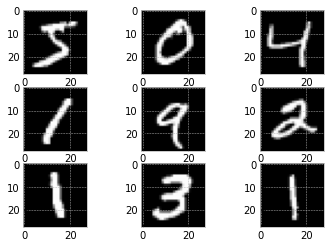

In [5]:
#load dataset
from tensorflow.keras.datasets import mnist
(trainX, trainy), (testX, testy) = mnist.load_data()
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))
# plot first few images
for i in range(9):
	plt.subplot(330 + 1 + i)
	plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
plt.show()

In [21]:
#config
image_crop_size =4
qProcessor = QuantumProcessor(image_crop_size)

#testing on 1 image
merged_img = qProcessor.quantumEdgeDetect(trainX[1],qProcessor)

total qbits  5


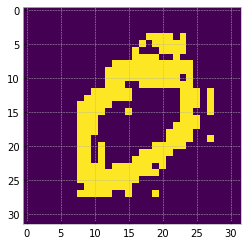

In [7]:
plt.imshow(merged_img)
plt.show()

In [22]:
# 32 x 32 because MNIST is resized to 32 pixels
trainNsample = 100
newTrainX = np.zeros((trainNsample, 32*32))
for i in range(trainNsample):
  newTrainX[i] = qProcessor.quantumEdgeDetect(trainX[i],qProcessor).flatten()
  if i%10==0:
    print('status :',i,'/',trainNsample)
testNsample = 50
newTestX = np.zeros((testNsample, 32*32))
for i in range(testNsample):
  newTestX[i] = qProcessor.quantumEdgeDetect(testX[i],qProcessor).flatten()
  if i%10==0:
    print('status :',i,'/',testNsample)

status : 0 / 100
status : 10 / 100
status : 20 / 100
status : 30 / 100
status : 40 / 100
status : 50 / 100
status : 60 / 100
status : 70 / 100
status : 80 / 100
status : 90 / 100
status : 0 / 50
status : 10 / 50
status : 20 / 50
status : 30 / 50
status : 40 / 50


In [23]:
from sklearn.linear_model import LogisticRegression
clf2 = LogisticRegression(fit_intercept=True,
                        multi_class='auto',
                        penalty='l1', #lasso regression
                        solver='saga',
                        max_iter=1000,
                        C=50,
                        verbose=2, # output progress
                        n_jobs=5, # parallelize over 5 processes
                        tol=0.01
                         )

clf2 = clf2.fit(newTrainX, trainy[:trainNsample])

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 28 epochs took 0 seconds


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.4s finished


In [29]:
clf2 = clf2.fit(newTrainX, trainy[:trainNsample])
print("Accuracy on test dataset = %3.2f" %(clf2.score(newTestX, testy[:testNsample])))

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


convergence after 30 epochs took 1 seconds
Accuracy on test dataset = 0.78


[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.5s finished


# Visualization

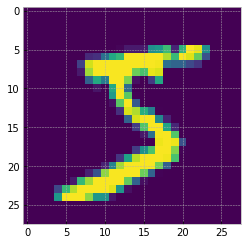

In [25]:
plt.imshow(trainX[0])
plt.show()

49


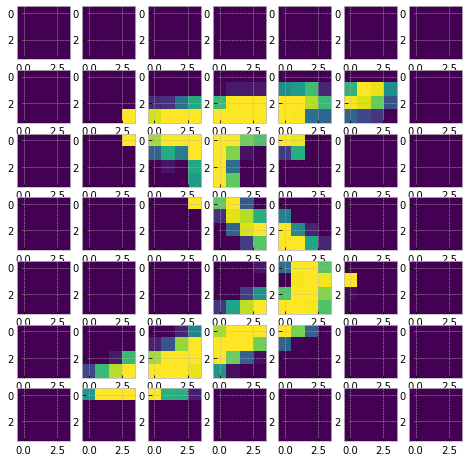

In [26]:
img_list = ImageUtils.split_image(trainX[0],4)
print(len(img_list))
fig = plt.figure(figsize=(8,8))
columns = rows= int(np.sqrt(len(img_list)))

for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_list[i-1])
plt.show()

64


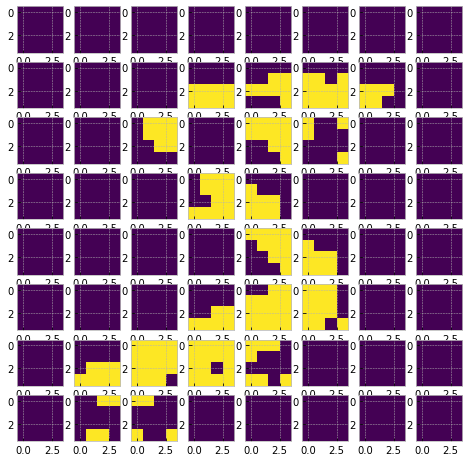

In [27]:
merged_img = qProcessor.quantumEdgeDetect(trainX[0],qProcessor)
img_list = ImageUtils.split_image(merged_img,4)
print(len(img_list))
fig = plt.figure(figsize=(8,8))
columns = rows= int(np.sqrt(len(img_list)))

for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_list[i-1])
plt.show()